Make each **Element** IRI exactly `EX[e]`, e.g. `https://example.org/springs#La` (no `Element_` prefix).  

**Pipeline**
- Load `s.xlsx` (or upload in Colab)
- Build RDF (`Site`, `Element`, `Measurement`) with `rdflib`
- Save Turtle
- Show a tiny **SPO** table for QC


In [1]:
!pip -q install rdflib openpyxl

In [2]:
from pathlib import Path
import pandas as pd

SPRINGS_XLSX = Path('/content/s.xlsx')
if not SPRINGS_XLSX.exists():
    SPRINGS_XLSX = Path('s.xlsx')

print('Using:', SPRINGS_XLSX.resolve())
df = pd.read_excel(SPRINGS_XLSX)

# numeric element columns
exclude = {'Site','lat','lon'}
for c in df.columns:
    if c not in exclude:
        df[c] = pd.to_numeric(df[c], errors='coerce')
elem_cols = sorted([c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])])

df.head(3)


Using: /content/s.xlsx


,Nb,Ti,Zr,Al,Ta,Hf,Fe,Y,Ga,Be,...,Ca,Sr,Mg,Sn,Se,Cd,Re,Site,lat,lon
0,2.637433e-08,1.511317e-08,0.000006,1.284812e-08,3.756685e-08,2.409195e-08,1.301236e-07,1.139674e-07,3.299441e-08,0.000006,...,0.001324,0.001005,0.001374,0.000003,8.828126e-07,0.000024,0.072193,PrestonBig,38.93376,-115.08144
1,2.723804e-08,1.488671e-08,0.000006,1.013251e-07,3.674941e-08,3.278891e-08,1.296682e-07,1.136926e-07,1.445943e-07,NaN,...,0.001265,0.000986,0.001355,0.000002,1.132953e-06,0.000026,0.136643,Nicholas,38.91042,-115.06088


In [3]:
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF, RDFS, XSD

g = Graph()

EX = Namespace('https://example.org/springs#')
GEO = Namespace('http://www.w3.org/2003/01/geo/wgs84_pos#')

g.bind('ex', EX)
g.bind('geo', GEO)
g.bind('rdf', RDF)
g.bind('rdfs', RDFS)
g.bind('xsd', XSD)

def slugify(s: str) -> str:
    import re
    s = str(s).strip()
    s = re.sub(r'\s+','_',s)
    s = re.sub(r'[^A-Za-z0-9_]', '', s)
    return s or 'SITE'

def iri_local(s: str) -> str:
    import re
    s = str(s).strip()
    s = re.sub(r'\s+', '_', s)
    s = re.sub(r'[^A-Za-z0-9_]', '', s)
    return s

Site = EX.Site
Element = EX.Element
Measurement = EX.Measurement

hasMeasurement = EX.hasMeasurement
ofElement = EX.ofElement
value = EX.value
unit = EX.unit

lat_prop = EX.lat
lon_prop = EX.lon

# Element URIs with **no prefix**: EX[e]
element_uris = {}
for e in elem_cols:
    el_uri = EX[iri_local(e)]     # e.g., EX['La'] => ...#La
    element_uris[e] = el_uri
    g.add((el_uri, RDF.type, Element))
    g.add((el_uri, RDFS.label, Literal(e)))

# Sites + measurements
for _, row in df.iterrows():
    sid = slugify(row['Site'])
    site_uri = EX[f'Site_{sid}']
    g.add((site_uri, RDF.type, Site))
    g.add((site_uri, RDFS.label, Literal(str(row['Site']))))

    if pd.notna(row.get('lat')):
        g.add((site_uri, lat_prop, Literal(float(row['lat']), datatype=XSD.float)))
    if pd.notna(row.get('lon')):
        g.add((site_uri, lon_prop, Literal(float(row['lon']), datatype=XSD.float)))

    for e in elem_cols:
        v = row[e]
        if pd.isna(v) or float(v) <= 0:
            continue
        m_uri = EX[f'M_{sid}_{iri_local(e)}']
        g.add((m_uri, RDF.type, Measurement))
        g.add((m_uri, ofElement, element_uris[e]))
        g.add((m_uri, value, Literal(float(v), datatype=XSD.double)))
        g.add((m_uri, unit, Literal('ppb')))
        g.add((site_uri, hasMeasurement, m_uri))

print('Triples:', len(g))


Triples: 521


In [4]:
# Export TTL
ttl_path = Path('/content/springs_NoPrefix.ttl')
ttl_path.write_text(g.serialize(format='turtle'), encoding='utf-8')
print('Wrote:', ttl_path)


Wrote: /content/springs_NoPrefix.ttl


In [5]:
# Minimal SPO preview
rows = []
for i, (s,p,o) in enumerate(g):
    rows.append((str(s), str(p), str(o)))
    if i > 1500:
        break

import pandas as pd
spo_df = pd.DataFrame(rows, columns=['S','P','O'])
spo_df.head(20)

,S,P,O
0,https://example.org/springs#Site_Nicholas,https://example.org/springs#hasMeasurement,https://example.org/springs#M_Nicholas_Ca
1,https://example.org/springs#Site_PrestonBig,https://example.org/springs#hasMeasurement,https://example.org/springs#M_PrestonBig_Hf
2,https://example.org/springs#M_PrestonBig_Fe,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,https://example.org/springs#Measurement
3,https://example.org/springs#M_PrestonBig_Li,https://example.org/springs#unit,ppb
4,https://example.org/springs#M_Nicholas_K,https://example.org/springs#unit,ppb
5,https://example.org/springs#Site_PrestonBig,https://example.org/springs#hasMeasurement,https://example.org/springs#M_PrestonBig_Sm
6,https://example.org/springs#M_PrestonBig_Al,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,https://example.org/springs#Measurement
7,https://example.org/springs#Site_Nicholas,https://example.org/springs#hasMeasurement,https://example.org/springs#M_Nicholas_Pr
8,https://example.org/springs#Site_Nicholas,https://example.org/springs#hasMeasurement,https://example.org/springs#M_Nicholas_Zn
9,https://example.org/springs#Ho,http://www.w3.org/2000/01/rdf-schema#label,Ho


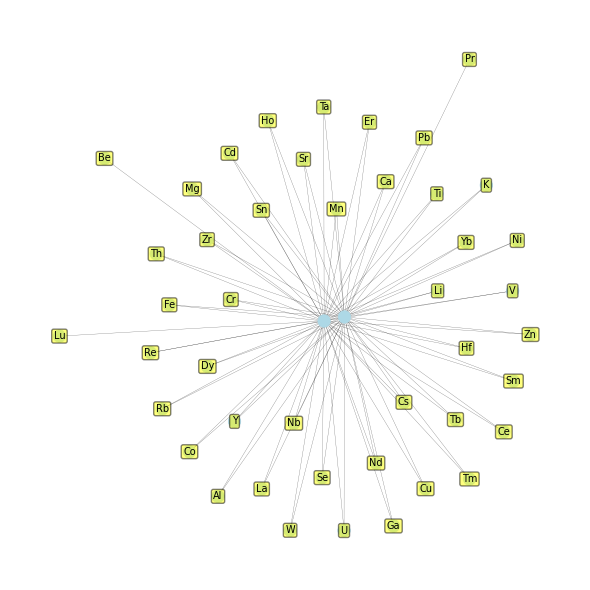

In [6]:
# Optional: a super-minimal graph view with networkx/matplotlib (tiny preview)
import networkx as nx
import matplotlib.pyplot as plt

# Build a small subgraph: sites + element nodes (skip Measurement nodes to keep it tiny)
G = nx.Graph()
for s, p, o in g.triples((None, RDF.type, EX.Site)):
    G.add_node(str(s), kind='site')
for e in element_uris.values():
    G.add_node(str(e), kind='element')

# Add edges if a site has measurement for that element
for s, p, m in g.triples((None, EX.hasMeasurement, None)):
    el = next(g.objects(m, EX.ofElement), None)
    if el is not None:
        G.add_edge(str(s), str(el))

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42, k=0.35)
node_colors = ['lightblue' if G.nodes[n].get('kind')=='site' else 'lightblue' for n in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=80, node_color=node_colors, linewidths=0.5)
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.6)
# Minimal labels just for elements to reduce clutter
labels = {n: n.split('#')[-1] for n in G.nodes if G.nodes[n].get('kind')=='element'}
nx.draw_networkx_labels(G, pos, labels, font_size=7, font_color='black',
                        bbox=dict(facecolor='yellow', alpha=0.5, pad=0.5, boxstyle='round,pad=0.2'))
plt.axis('off')
plt.tight_layout()
plt.show()

/tmp/ipython-input-1760940749.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


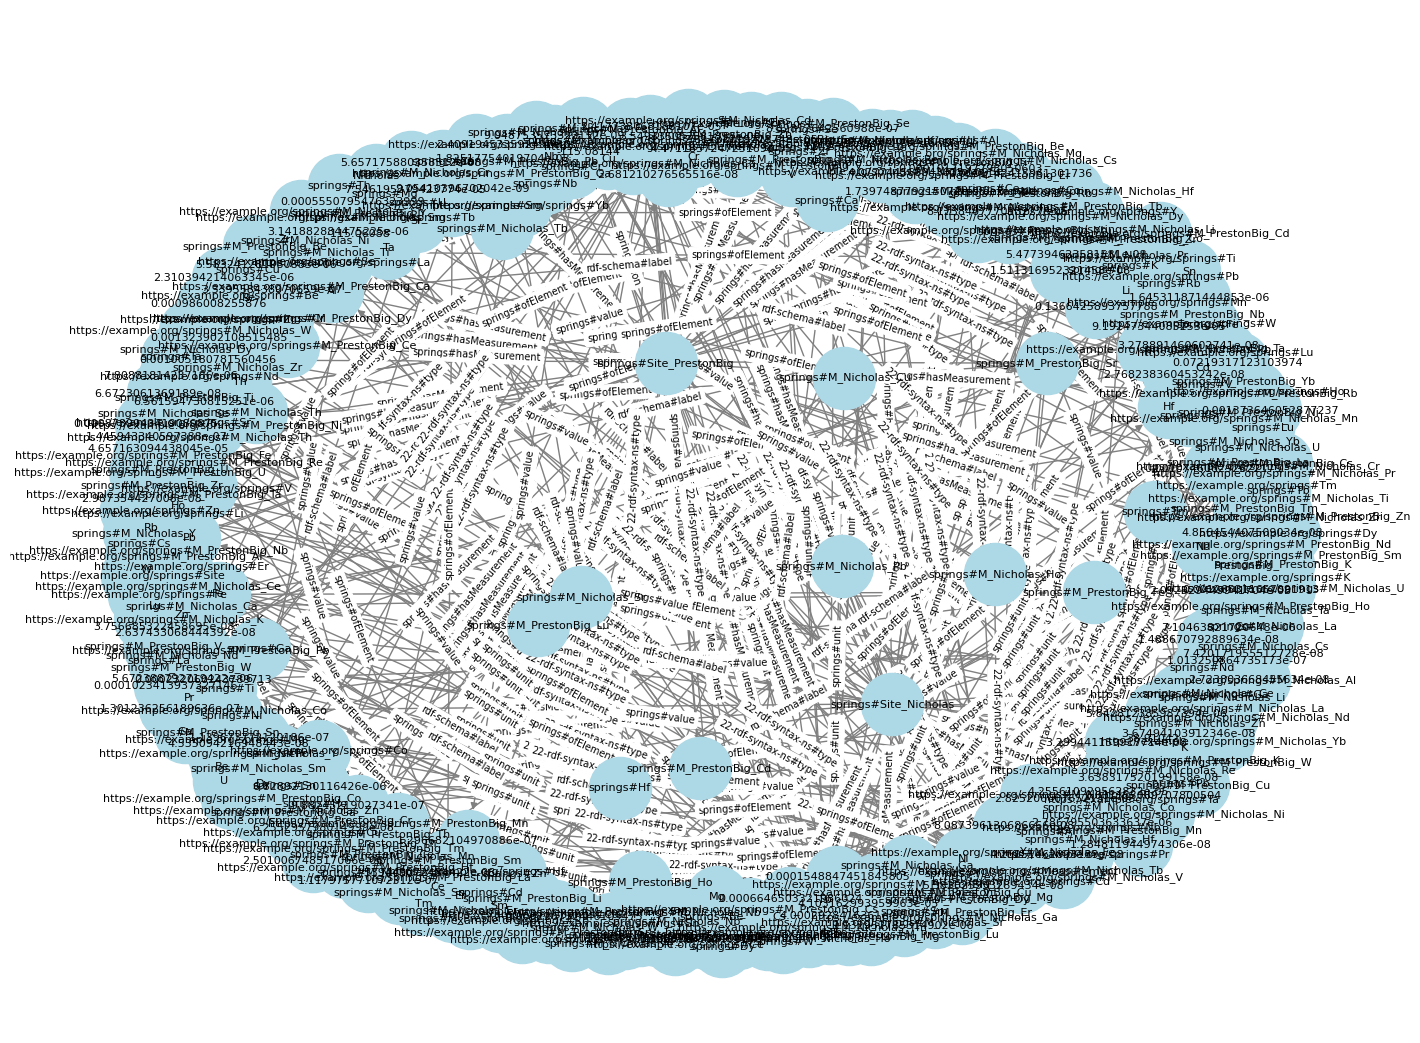

In [7]:
# Convert to NetworkX graph for visualization
nx_graph = nx.MultiDiGraph()
for subj, pred, obj in g:
    nx_graph.add_edge(str(subj).split("/")[-1], str(obj), label=str(pred).split("/")[-1])

# Draw the graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(nx_graph, k=1.3)
nx.draw(nx_graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=8)
edge_labels = nx.get_edge_attributes(nx_graph, 'label')
nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_size=7)
plt.title(" ", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig("/content/springs_rdf_graph.png")
plt.show()